# GSM8K pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_rollouts/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint. RL runs are restricted to the 6 experiments under `/n/netscratch/dam_lab/Everyone/rl_rollouts/experiments/` (fixed_n5/n64 × easy/hard/balanced).



In [1]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Root location for evaluation outputs
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_rollouts/eval_results")

# Restrict RL runs to these 6 experiment directories only
ALLOWED_RL_EXPERIMENTS = {
    "fixed_n5_hard_epochs100_58022458",
    "fixed_n5_easy_epochs100_58022463",
    "fixed_n5_balanced_epochs100_58022453",
    "fixed_n64_hard_epochs5_57501197",
    "fixed_n64_easy_epochs5_57501190",
    "fixed_n64_balanced_epochs5_57501202",
}

print(f"Base directory: {BASE_DIR}")
print(f"Available: {BASE_DIR.exists()}")
print(f"Restricted to {len(ALLOWED_RL_EXPERIMENTS)} experiments: {sorted(ALLOWED_RL_EXPERIMENTS)}")

Base directory: /n/netscratch/dam_lab/Everyone/rl_rollouts/eval_results
Available: True
Restricted to 6 experiments: ['fixed_n5_balanced_epochs100_58022453', 'fixed_n5_easy_epochs100_58022463', 'fixed_n5_hard_epochs100_58022458', 'fixed_n64_balanced_epochs5_57501202', 'fixed_n64_easy_epochs5_57501190', 'fixed_n64_hard_epochs5_57501197']


In [2]:
def read_score(result_path: Path, metric: str = "pass@1", dataset_key: str = None):
    """Read score from either dict-style logs or majority-vote text files.

    Args:
        result_path: Path to the result file
        metric: One of "pass@1", "pass@32", or "single" (single sample accuracy)
        dataset_key: Optional key to look for in dict-style logs (e.g., "test_score/openai/gsm8k")
    
    Returns:
        float score or None if not found
    """
    if not result_path.exists():
        return None

    text = result_path.read_text().splitlines()

    # For majority_results.txt files, parse the text format
    if "majority" in result_path.name:
        for line in text:
            # Handle "Single Sample Accuracy: 0.4928 (49.28%)"
            if metric in ["pass@1", "single"] and "Single Sample Accuracy" in line:
                parts = line.split(":")
                if len(parts) > 1:
                    try:
                        return float(parts[1].split()[0])
                    except Exception:
                        pass
            
            # Handle "Pass@32 (Any Correct): 0.6884 (68.84%)"
            if (metric == "pass@32" or metric == "pass@8") and "Pass@" in line and "Any Correct" in line:
                parts = line.split(":")
                if len(parts) > 1:
                    try:
                        return float(parts[1].split()[0])
                    except Exception:
                        pass
        return None

    # For regular results.txt files, parse dict-style log
    if dataset_key is None:
        # Infer dataset key from filename
        if "gsm8k" in result_path.name:
            dataset_key = "test_score/openai/gsm8k"
        elif "math" in result_path.name:
            dataset_key = "test_score/math"
        else:
            dataset_key = "test_score"
    
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return payload[dataset_key]
    return None


# Pattern for base model results: 1B-{id}-{shot}shot-{samples}samples-temp{temp}
base_pattern = re.compile(r"1B-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Pattern for RL runs: fixed_n{rollouts}_{dataset}_{split}_epochs{epochs}_{job_id}-step{rl_step}-rl-...
# Also handles: fixed_n{rollouts}_{dataset}_{job_id}-step{rl_step}-rl-... (no split/epochs)
rl_pattern = re.compile(
    r"fixed_n(?P<num_rollouts>\d+)_(?P<dataset>\w+?)_?"
    r"(?:(?P<split>easy|hard|balanced|5000)_?)?"
    r"(?:epochs?(?P<epochs>\d+)_?)?"
    r"(?P<job_id>\d+)-step(?P<rl_step>\d+)-rl-"
    r"(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"
)

# Collect base model results
base_rows = []
# Collect RL results
rl_rows = []

for path in BASE_DIR.iterdir():
    if not path.is_dir():
        continue
    name = path.name

    # Base model collection
    base_match = base_pattern.match(name)
    if base_match and "rl" not in name.lower():
        samples = int(base_match.group("samples"))
        # model_id = base_match.group("model_id")
        model_id = "0425"
        
        # Read GSM8K scores
        if samples == 1:
            gsm8k_file = path / "gsm8k_results.txt"
            gsm8k = read_score(gsm8k_file if gsm8k_file.exists() else path / "gsm8k_results.txt", 
                                metric="pass@1", dataset_key="test_score/openai/gsm8k") if gsm8k_file.exists() else None
        
            # Read MATH scores
            math_file = path / "math_results.txt"
            math = read_score(math_file if math_file.exists() else path / "math_results.txt",
                                metric="pass@1", dataset_key="test_score/math") if math_file.exists() else None
        else:
            gsm8k_majority_file = path / "gsm8k_majority_results.txt"
            gsm8k = read_score(gsm8k_majority_file, metric=f"pass@{samples}") if gsm8k_majority_file.exists() else None
        
            math_majority_file = path / "math_majority_results.txt"
            math = read_score(math_majority_file, metric=f"pass@{samples}") if math_majority_file.exists() else None
        
        base_rows.append({
            "model_id": model_id,
            "shot": int(base_match.group("shot")),
            "samples": samples,
            "temp": float(base_match.group("temp")),
            f"gsm8k_p{samples}": gsm8k,
            f"math_p{samples}": math,
            "path": str(path),
        })
        continue

    # RL collection
    rl_match = rl_pattern.match(name)
    if rl_match:
        # Restrict to allowed experiments only (experiment ID is prefix before -step)
        exp_id = name.split("-step")[0] if "-step" in name else None
        if exp_id not in ALLOWED_RL_EXPERIMENTS:
            continue
        num_rollouts = int(rl_match.group("num_rollouts"))
        dataset = rl_match.group("dataset")  # e.g., "gsm8k" or "math"
        split = rl_match.group("split")  # e.g., "easy", "hard", "balanced", "5000", or None
        epochs = int(rl_match.group("epochs")) if rl_match.group("epochs") else None
        job_id = rl_match.group("job_id")
        rl_step = int(rl_match.group("rl_step"))
        samples = int(rl_match.group("samples"))
        
        # Determine train_data label
        if dataset == "math":
            train_data = f"math_{split}" if split else "math"
        else:
            train_data = f"{dataset}_{split}" if split else dataset
        
        if not ((num_rollouts == 5 and epochs == 100) or (num_rollouts == 64 and epochs == 5)):
            continue
        
        if num_rollouts == 5:
            config_type = "n5"
        elif num_rollouts == 64:
            if epochs == 5 or epochs == 10 or epochs == 100:
                config_type = "n64"  # Same sample exposure as n=5
            else:
                config_type = "n64_same_batch"  # Same batch size as n=5
        else:
            config_type = f"n{num_rollouts}"
        
        # Read GSM8K scores
        if samples == 1:
            gsm8k_file = path / "gsm8k_results.txt"
            gsm8k = read_score(gsm8k_file, metric="pass@1", dataset_key="test_score/openai/gsm8k") if gsm8k_file.exists() else None

            # Read MATH scores
            math_file = path / "math_results.txt"
            math = read_score(math_file, metric="pass@1", dataset_key="test_score/math") if math_file.exists() else None
        else:
            gsm8k_majority_file = path / "gsm8k_majority_results.txt"
            gsm8k = read_score(gsm8k_majority_file, metric=f"pass@{samples}") if gsm8k_majority_file.exists() else None
        
            math_majority_file = path / "math_majority_results.txt"
            math = read_score(math_majority_file, metric=f"pass@{samples}") if math_majority_file.exists() else None
        
        # Calculate FLOPs and samples seen
        # Batch size is 128 prompts per step for all experiments
        BATCH_SIZE = 128
        # FLOPs are proportional to: batch_size × n_rollouts × steps (more rollouts = more forward passes)
        flops_consumed = BATCH_SIZE * num_rollouts * rl_step
        # Samples seen = prompts processed = batch_size × steps (regardless of rollouts per prompt)
        samples_seen = BATCH_SIZE * rl_step
        
        rl_rows.append({
            "num_rollouts": num_rollouts,
            "config_type": config_type,
            "train_data": train_data,
            "dataset": dataset,
            "split": split,
            "epochs": epochs,
            "job_id": job_id,
            "rl_step": rl_step,
            "flops_consumed": flops_consumed,  # Relative FLOPs (proportional to actual FLOPs)
            "samples_seen": samples_seen,  # Number of prompts seen
            "samples": samples,
            "temp": float(rl_match.group("temp")),
            f"gsm8k_p{samples}": gsm8k,
            f"math_p{samples}": math,
            "path": str(path),
            "label": name,
        })

base_df = pd.DataFrame(base_rows)
rl_df = pd.DataFrame(rl_rows)

print(f"Loaded {len(base_df)} base model runs, {len(rl_df)} RL runs.")
print(f"\nBase model IDs: {sorted(base_df['model_id'].unique()) if not base_df.empty else 'None'}")
print(f"\nRL train data splits: {sorted(rl_df['train_data'].unique()) if not rl_df.empty else 'None'}")
print(f"RL num_rollouts: {sorted(rl_df['num_rollouts'].unique()) if not rl_df.empty else 'None'}")
print(f"RL config_types: {sorted(rl_df['config_type'].unique()) if not rl_df.empty else 'None'}")

Loaded 3 base model runs, 1238 RL runs.

Base model IDs: ['0425']

RL train data splits: ['balanced', 'easy', 'hard']
RL num_rollouts: [5, 64]
RL config_types: ['n5', 'n64']


In [3]:
# Display base model results
print("=== Base Model Results ===")
if not base_df.empty:
    display(base_df.sort_values(["model_id", "shot", "samples"]))
else:
    print("No base model results found")

print("\n=== RL Results ===")
if not rl_df.empty:
    display(rl_df.sort_values(["train_data", "num_rollouts", "rl_step"]))
else:
    print("No RL results found")

=== Base Model Results ===


,model_id,shot,samples,temp,gsm8k_p1,math_p1,path,gsm8k_p32,math_p32,gsm8k_p8,math_p8
0,0425,0,1,0.6,0.128127,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,NaN,NaN,NaN,NaN
2,0425,0,8,0.6,NaN,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,NaN,NaN,0.5004,NaN
1,0425,0,32,0.6,NaN,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,0.7422,NaN,NaN,NaN



=== RL Results ===


,num_rollouts,config_type,train_data,dataset,split,epochs,job_id,rl_step,flops_consumed,samples_seen,samples,temp,gsm8k_p8,math_p8,path,label,gsm8k_p1,math_p1,gsm8k_p32,math_p32
0,5,n5,balanced,balanced,None,100,58022453,10,6400,1280,8,0.6,0.7058,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n5_balanced_epochs100_58022453-step10-rl...,NaN,NaN,NaN,NaN
133,5,n5,balanced,balanced,None,100,58022453,20,12800,2560,8,0.6,0.7430,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n5_balanced_epochs100_58022453-step20-rl...,NaN,NaN,NaN,NaN
266,5,n5,balanced,balanced,None,100,58022453,30,19200,3840,8,0.6,0.7392,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n5_balanced_epochs100_58022453-step30-rl...,NaN,NaN,NaN,NaN
379,5,n5,balanced,balanced,None,100,58022453,40,25600,5120,8,0.6,0.7627,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n5_balanced_epochs100_58022453-step40-rl...,NaN,NaN,NaN,NaN
412,5,n5,balanced,balanced,None,100,58022453,50,32000,6400,1,0.6,NaN,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n5_balanced_epochs100_58022453-step50-rl...,0.473844,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,64,n64,hard,hard,None,5,57501197,300,2457600,38400,8,0.6,0.8249,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n64_hard_epochs5_57501197-step300-rl-0sh...,NaN,NaN,NaN,NaN
1221,64,n64,hard,hard,None,5,57501197,310,2539520,39680,1,0.6,NaN,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n64_hard_epochs5_57501197-step310-rl-0sh...,0.639121,NaN,NaN,NaN
1222,64,n64,hard,hard,None,5,57501197,310,2539520,39680,8,0.6,0.8287,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n64_hard_epochs5_57501197-step310-rl-0sh...,NaN,NaN,NaN,NaN
1223,64,n64,hard,hard,None,5,57501197,320,2621440,40960,1,0.6,NaN,NaN,/n/netscratch/dam_lab/Everyone/rl_rollouts/eva...,fixed_n64_hard_epochs5_57501197-step320-rl-0sh...,0.636846,NaN,NaN,NaN


In [4]:
# Get base model score for reference
BASE_MODEL_ID = "0425"  # The base model identifier
base_model = base_df[base_df["model_id"] == BASE_MODEL_ID]

if not base_model.empty:
    base_gsm8k_p1 = base_model[base_model["samples"] == 1]["gsm8k_p1"].iloc[0]
    base_gsm8k_p8 = base_model[base_model["samples"] == 8]["gsm8k_p8"].iloc[0]
    base_gsm8k_p32 = base_model[base_model["samples"] == 32]["gsm8k_p32"].iloc[0]
    base_math_p1 = base_model["math_p1"].iloc[0]
    base_math_p32 = base_model["math_p32"].iloc[0]
    print(f"Base model ({BASE_MODEL_ID}) scores:")
    print(f"  GSM8K pass@1: {base_gsm8k_p1:.4f}" if base_gsm8k_p1 else "  GSM8K pass@1: N/A")
    print(f"  GSM8K pass@32: {base_gsm8k_p32:.4f}" if base_gsm8k_p32 else "  GSM8K pass@32: N/A")
    print(f"  MATH pass@1: {base_math_p1:.4f}" if base_math_p1 else "  MATH pass@1: N/A")
    print(f"  MATH pass@32: {base_math_p32:.4f}" if base_math_p32 else "  MATH pass@32: N/A")
else:
    base_gsm8k_p1, base_gsm8k_p32, base_math_p1, base_math_p32 = None, None, None, None
    print("No base model found")



Base model (0425) scores:
  GSM8K pass@1: 0.1281
  GSM8K pass@32: 0.7422
  MATH pass@1: nan
  MATH pass@32: nan


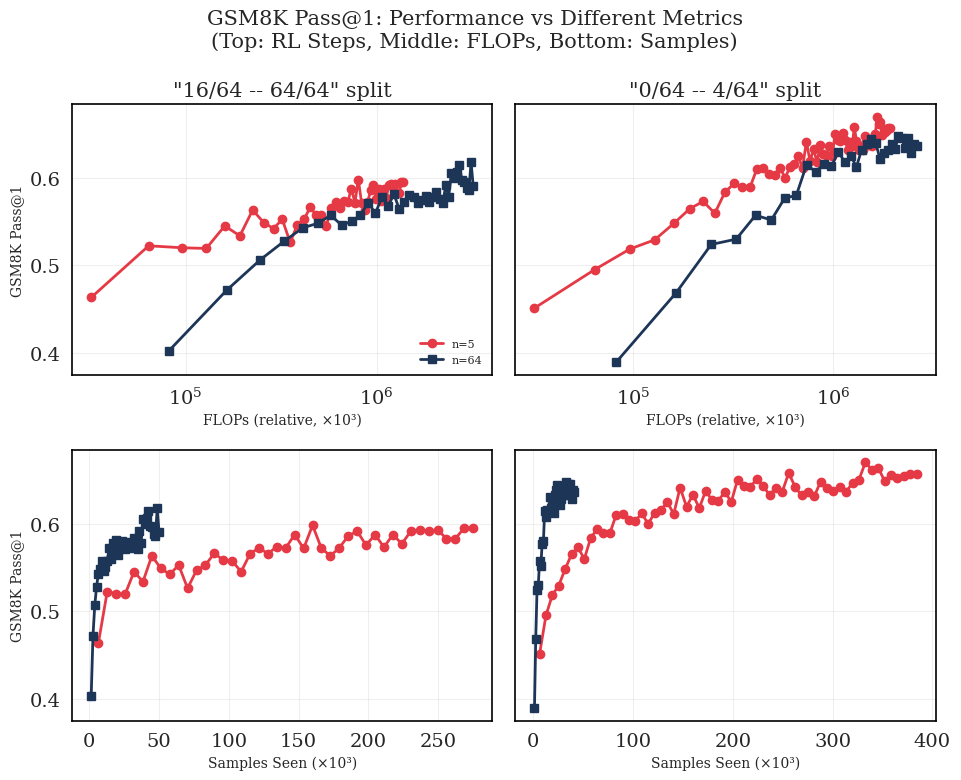

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 1. Setup Theme
sns.set_theme(style="whitegrid", context="paper", font_scale=1.6)

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
})

# Constants
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
SFT_EPOCHS = 10
SFTED_RL_ROLLOUTS = 32
TOKEN_MULTIPLIER = 2_000_000

# 2. COLOR PALETTE (Okabe-Ito / High Contrast)
color_base = "#777777"     # Gray
color_rl = "#E24A33"       # Red
color_sft = "#009E73"      # Emerald Green
color_sfted_rl = "#0072B2" # Royal Blue

# 3. Styles
styles = {
    "pretrain": {
        "color": color_base, 
        "marker": "o", "ls": ":", "markersize": 10,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t$ (Base)"
    },
    "sft": {
        "color": color_sft, 
        "marker": "d", "ls": "-.", "markersize": 12,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t^{\text{SFT}}$"
    },
    "sfted_rl": {
        "color": color_sfted_rl, 
        "marker": "d", "ls": "--", "markersize": 12,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t^{\text{SFT} \rightarrow \text{RL}}$"
    },
    "rl": {
        "color": color_rl, 
        "marker": "*", "ls": "-", "markersize": 18,
        "linewidth": 3.5,
        "label": r"$\mathcal{M}_t^{\text{RL}}$"
    }
}

# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# X-axis formatter
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.0f%s' % (num, ['', 'K', 'M', 'B', 'T'][magnitude])
formatter = FuncFormatter(human_format)

# # Plot 1: GSM8K Pass@1 performance for different rollout configs and data splits
# # Three plots per data split: (1) vs RL step, (2) vs FLOPs consumed, (3) vs Samples seen
# # This helps analyze FLOP-limited vs sample-limited regimes

# plt.style.use("seaborn-v0_8-whitegrid")

# Filter out rows with missing gsm8k_p1 scores; only easy and hard splits
rl_valid = rl_df[rl_df["gsm8k_p1"].notna()].copy()
rl_valid = rl_valid[rl_valid["train_data"].isin(["easy", "hard"])]

if rl_valid.empty:
    print("No valid GSM8K Pass@1 results found")
else:
    train_data_list = ["easy", "hard"]
    n_splits = len(train_data_list)
    split_labels = {"easy": '"16/64 -- 64/64" split', "hard": '"0/64 -- 4/64" split'}
    
    # Color palette and markers for different config_types
    colors = {"n5": "#e63946", "n64": "#1d3557"}
    markers = {"n5": "o", "n64": "s"}
    labels = {"n5": "n=5", "n64": "n=64"}
    
    # X-axis options: (column_name, label, base_value, scale_factor for display)
    x_axis_options = [
        # ("rl_step", "RL Step", 0, 1),
        ("flops_consumed", "FLOPs (relative, ×10³)", 0, 1),
        ("samples_seen", "Samples Seen (×10³)", 0, 1/1000),
    ]
    
    # Create 3 rows of plots (one for each x-axis type)
    fig, axes = plt.subplots(len(x_axis_options), n_splits, figsize=(5 * n_splits, 4 * len(x_axis_options)), sharey='row')
    if n_splits == 1:
        axes = axes.reshape(-1, 1)
    
    for row_idx, (x_col, x_label, base_x, scale) in enumerate(x_axis_options):
        for col_idx, train_data in enumerate(train_data_list):
            ax = axes[row_idx, col_idx]
            subset = rl_valid[rl_valid["train_data"] == train_data]
            
            # Plot for each config_type, starting from base model at x=0
            for cfg_type in ["n5", "n64"]:
                cfg_data = subset[subset["config_type"] == cfg_type].sort_values(x_col)
                if cfg_data.empty:
                    continue
                color = colors.get(cfg_type, "#457b9d")
                marker = markers.get(cfg_type, "^")
                label = labels.get(cfg_type, cfg_type)
                
                # Prepend base model score at x=0
                if base_gsm8k_p1 is not None and False:
                    x_vals = [base_x] + (cfg_data[x_col] * scale).tolist()
                    scores = [base_gsm8k_p1] + cfg_data["gsm8k_p1"].tolist()
                else:
                    x_vals = (cfg_data[x_col] * scale).tolist()
                    scores = cfg_data["gsm8k_p1"].tolist()
                
                ax.plot(x_vals, scores, 
                       marker=marker, color=color, linewidth=2, markersize=6,
                       label=label if col_idx == 0 else None)
            
            if row_idx == 0:
                ax.set_title(split_labels.get(train_data, train_data), fontsize=15)
            
            if "flops" in x_label.lower():
                ax.set_xscale("log")

            ax.set_xlabel(x_label, fontsize=10)
            if col_idx == 0:
                ax.set_ylabel("GSM8K Pass@1", fontsize=10)
            ax.grid(True, alpha=0.3)
            if col_idx == 0 and row_idx == 0:
                ax.legend(loc="lower right", fontsize=8)
    
    fig.suptitle("GSM8K Pass@1: Performance vs Different Metrics\n(Top: RL Steps, Middle: FLOPs, Bottom: Samples)", fontsize=15)
    plt.tight_layout()
    plt.savefig("gsm8k_rollouts_p1.pdf", dpi=150, bbox_inches="tight", format="pdf")
    plt.show()


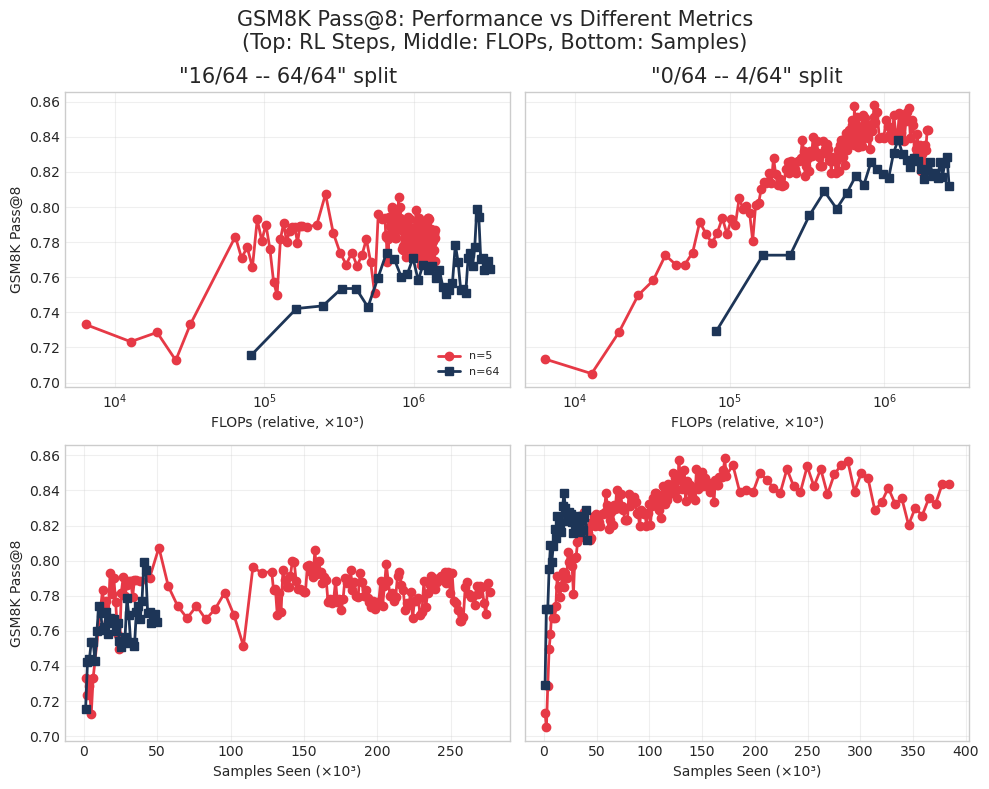

In [6]:
# Plot 1: GSM8K Pass@1 performance for different rollout configs and data splits
# Three plots per data split: (1) vs RL step, (2) vs FLOPs consumed, (3) vs Samples seen
# This helps analyze FLOP-limited vs sample-limited regimes

plt.style.use("seaborn-v0_8-whitegrid")

# Filter out rows with missing gsm8k_p8 scores; only easy and hard splits
rl_valid = rl_df[rl_df["gsm8k_p8"].notna()].copy()
rl_valid = rl_valid[rl_valid["train_data"].isin(["easy", "hard"])]

if rl_valid.empty:
    print("No valid GSM8K Pass@1 results found")
else:
    train_data_list = ["easy", "hard"]
    n_splits = len(train_data_list)
    split_labels = {"easy": '"16/64 -- 64/64" split', "hard": '"0/64 -- 4/64" split'}
    
    # Color palette and markers for different config_types
    colors = {"n5": "#e63946", "n64": "#1d3557"}
    markers = {"n5": "o", "n64": "s"}
    labels = {"n5": "n=5", "n64": "n=64"}
    
    # X-axis options: (column_name, label, base_value, scale_factor for display)
    x_axis_options = [
        # ("rl_step", "RL Step", 0, 1),
        ("flops_consumed", "FLOPs (relative, ×10³)", 0, 1),
        ("samples_seen", "Samples Seen (×10³)", 0, 1/1000),
    ]
    
    # Create 3 rows of plots (one for each x-axis type)
    fig, axes = plt.subplots(len(x_axis_options), n_splits, figsize=(5 * n_splits, 4 * len(x_axis_options)), sharey='row')
    if n_splits == 1:
        axes = axes.reshape(-1, 1)
    
    for row_idx, (x_col, x_label, base_x, scale) in enumerate(x_axis_options):
        for col_idx, train_data in enumerate(train_data_list):
            ax = axes[row_idx, col_idx]
            subset = rl_valid[rl_valid["train_data"] == train_data]
            
            # Plot for each config_type, starting from base model at x=0
            for cfg_type in ["n5", "n64"]:
                cfg_data = subset[subset["config_type"] == cfg_type].sort_values(x_col)
                if cfg_data.empty:
                    continue
                color = colors.get(cfg_type, "#457b9d")
                marker = markers.get(cfg_type, "^")
                label = labels.get(cfg_type, cfg_type)
                
                # Prepend base model score at x=0
                if base_gsm8k_p8 is not None and False:
                    x_vals = [base_x] + (cfg_data[x_col] * scale).tolist()
                    scores = [base_gsm8k_p8] + cfg_data["gsm8k_p8"].tolist()
                else:
                    x_vals = (cfg_data[x_col] * scale).tolist()
                    scores = cfg_data["gsm8k_p8"].tolist()
                
                ax.plot(x_vals, scores, 
                       marker=marker, color=color, linewidth=2, markersize=6,
                       label=label if col_idx == 0 else None)
            
            if row_idx == 0:
                ax.set_title(split_labels.get(train_data, train_data), fontsize=15)
            
            if "flops" in x_label.lower():
                ax.set_xscale("log")

            ax.set_xlabel(x_label, fontsize=10)
            if col_idx == 0:
                ax.set_ylabel("GSM8K Pass@8", fontsize=10)
            ax.grid(True, alpha=0.3)
            if col_idx == 0 and row_idx == 0:
                ax.legend(loc="lower right", fontsize=8)
    
    fig.suptitle("GSM8K Pass@8: Performance vs Different Metrics\n(Top: RL Steps, Middle: FLOPs, Bottom: Samples)", fontsize=15)
    plt.tight_layout()
    plt.savefig("gsm8k_rollouts_p8.pdf", dpi=150, bbox_inches="tight", format="pdf")
    plt.show()


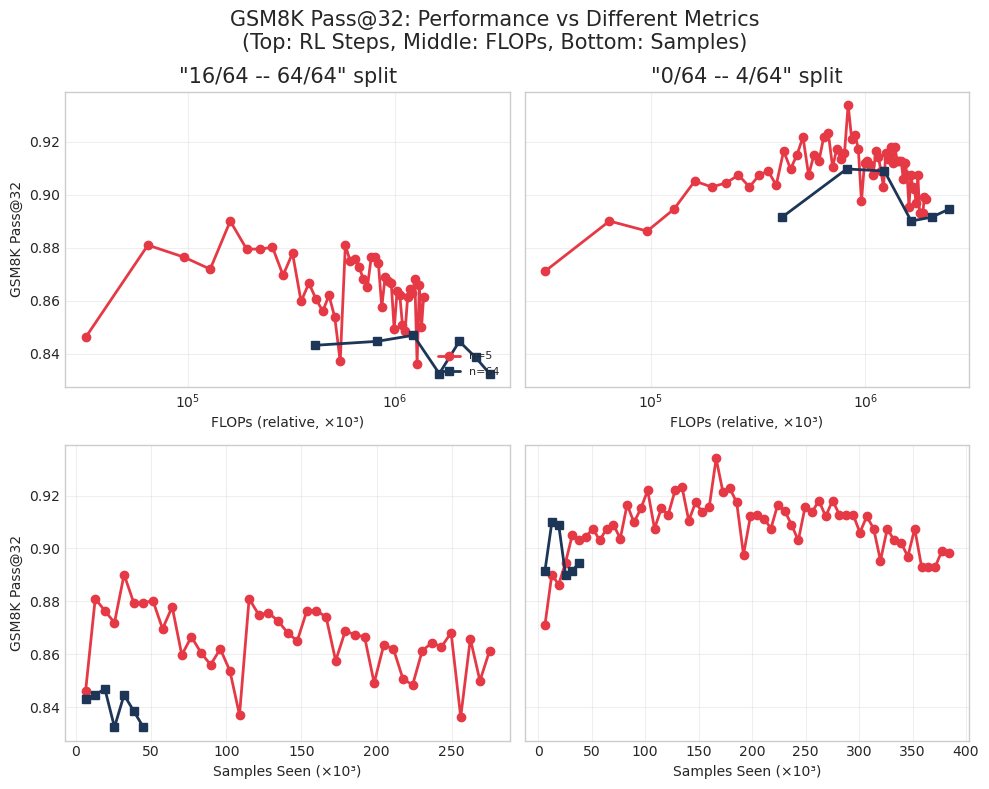

In [10]:
# Plot 1: GSM8K Pass@1 performance for different rollout configs and data splits
# Three plots per data split: (1) vs RL step, (2) vs FLOPs consumed, (3) vs Samples seen
# This helps analyze FLOP-limited vs sample-limited regimes

plt.style.use("seaborn-v0_8-whitegrid")

# Filter out rows with missing gsm8k_p32 scores; only easy and hard splits
rl_valid = rl_df[rl_df["gsm8k_p32"].notna()].copy()
rl_valid = rl_valid[rl_valid["train_data"].isin(["easy", "hard"])]

if rl_valid.empty:
    print("No valid GSM8K Pass@1 results found")
else:
    train_data_list = ["easy", "hard"]
    n_splits = len(train_data_list)
    split_labels = {"easy": '"16/64 -- 64/64" split', "hard": '"0/64 -- 4/64" split'}
    
    # Color palette and markers for different config_types
    colors = {"n5": "#e63946", "n64": "#1d3557"}
    markers = {"n5": "o", "n64": "s"}
    labels = {"n5": "n=5", "n64": "n=64"}
    
    # X-axis options: (column_name, label, base_value, scale_factor for display)
    x_axis_options = [
        # ("rl_step", "RL Step", 0, 1),
        ("flops_consumed", "FLOPs (relative, ×10³)", 0, 1),
        ("samples_seen", "Samples Seen (×10³)", 0, 1/1000),
    ]
    
    # Create 3 rows of plots (one for each x-axis type)
    fig, axes = plt.subplots(len(x_axis_options), n_splits, figsize=(5 * n_splits, 4 * len(x_axis_options)), sharey='row')
    if n_splits == 1:
        axes = axes.reshape(-1, 1)
    
    for row_idx, (x_col, x_label, base_x, scale) in enumerate(x_axis_options):
        for col_idx, train_data in enumerate(train_data_list):
            ax = axes[row_idx, col_idx]
            subset = rl_valid[rl_valid["train_data"] == train_data]
            
            # Plot for each config_type, starting from base model at x=0
            for cfg_type in ["n5", "n64"]:
                cfg_data = subset[subset["config_type"] == cfg_type].sort_values(x_col)
                if cfg_data.empty:
                    continue
                color = colors.get(cfg_type, "#457b9d")
                marker = markers.get(cfg_type, "^")
                label = labels.get(cfg_type, cfg_type)
                
                # Prepend base model score at x=0
                if base_gsm8k_p32 is not None and False:
                    x_vals = [base_x] + (cfg_data[x_col] * scale).tolist()
                    scores = [base_gsm8k_p32] + cfg_data["gsm8k_p32"].tolist()
                else:
                    x_vals = (cfg_data[x_col] * scale).tolist()
                    scores = cfg_data["gsm8k_p32"].tolist()
                
                ax.plot(x_vals, scores, 
                       marker=marker, color=color, linewidth=2, markersize=6,
                       label=label if col_idx == 0 else None)
            
            if row_idx == 0:
                ax.set_title(split_labels.get(train_data, train_data), fontsize=15)
            
            if "flops" in x_label.lower():
                ax.set_xscale("log")

            ax.set_xlabel(x_label, fontsize=10)
            if col_idx == 0:
                ax.set_ylabel("GSM8K Pass@32", fontsize=10)
            ax.grid(True, alpha=0.3)
            if col_idx == 0 and row_idx == 0:
                ax.legend(loc="lower right", fontsize=8)
    
    fig.suptitle("GSM8K Pass@32: Performance vs Different Metrics\n(Top: RL Steps, Middle: FLOPs, Bottom: Samples)", fontsize=15)
    plt.tight_layout()
    plt.savefig("gsm8k_rollouts_p32.pdf", dpi=150, bbox_inches="tight", format="pdf")
    plt.show()


/tmp/ipykernel_3869932/1649840472.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


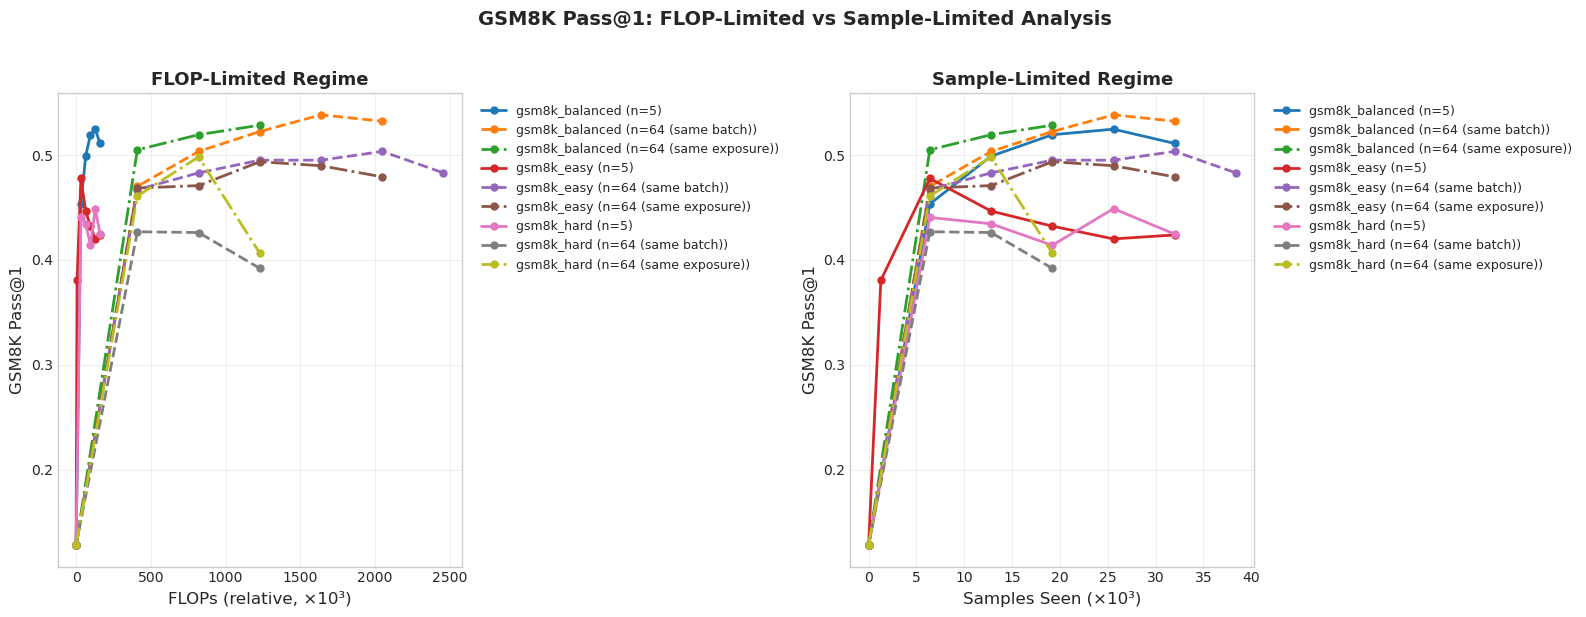

In [8]:
# Plot 2: All configurations comparison - FLOPs-limited vs Sample-limited view
# Left: Performance vs FLOPs (FLOP-limited regime)
# Right: Performance vs Samples seen (Sample-limited regime)

plt.style.use("seaborn-v0_8-whitegrid")

rl_valid = rl_df[rl_df["gsm8k_p1"].notna()].copy()

if not rl_valid.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    configs = rl_valid.groupby(["train_data", "config_type"]).size().reset_index()[["train_data", "config_type"]]
    cmap = plt.cm.get_cmap("tab10")
    linestyles = {"n5": "-", "n64_same_batch": "--", "n64_same_exposure": "-."}
    config_labels = {"n5": "n=5", "n64_same_batch": "n=64 (same batch)", "n64_same_exposure": "n=64 (same exposure)"}
    
    x_options = [
        ("flops_consumed", "FLOPs (relative, ×10³)", 1/1000, "FLOP-Limited Regime"),
        ("samples_seen", "Samples Seen (×10³)", 1/1000, "Sample-Limited Regime"),
    ]
    
    for ax_idx, (x_col, x_label, scale, title) in enumerate(x_options):
        ax = axes[ax_idx]
        
        for i, (_, config) in enumerate(configs.iterrows()):
            train_data = config["train_data"]
            cfg_type = config["config_type"]
            
            data = rl_valid[(rl_valid["train_data"] == train_data) & 
                           (rl_valid["config_type"] == cfg_type)].sort_values(x_col)
            
            color = cmap(i % 10)
            ls = linestyles.get(cfg_type, "-")
            label = config_labels.get(cfg_type, cfg_type)
            
            # Prepend base model score at x=0
            if base_gsm8k_p1 is not None:
                x_vals = [0] + (data[x_col] * scale).tolist()
                scores = [base_gsm8k_p1] + data["gsm8k_p1"].tolist()
            else:
                x_vals = (data[x_col] * scale).tolist()
                scores = data["gsm8k_p1"].tolist()
            
            ax.plot(x_vals, scores,
                   marker="o", color=color, linestyle=ls, linewidth=2, markersize=5,
                   label=f"{train_data} ({label})")
        
        ax.set_xlabel(x_label, fontsize=12)
        ax.set_ylabel("GSM8K Pass@1", fontsize=12)
        ax.set_title(title, fontsize=13, fontweight="bold")
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle("GSM8K Pass@1: FLOP-Limited vs Sample-Limited Analysis", fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.savefig("gsm8k_flop_vs_sample_limited.png", dpi=150, bbox_inches="tight")
    plt.show()


In [9]:
# Plot 3: MATH performance for different rollout configs and data splits
# Three plots per data split: (1) vs RL step, (2) vs FLOPs consumed, (3) vs Samples seen

plt.style.use("seaborn-v0_8-whitegrid")

rl_math_valid = rl_df[rl_df["math_p1"].notna()].copy()

if not rl_math_valid.empty:
    train_data_list = sorted(rl_math_valid["train_data"].unique())
    n_splits = len(train_data_list)
    
    colors = {"n5": "#e63946", "n64_same_batch": "#1d3557", "n64_same_exposure": "#2a9d8f"}
    markers = {"n5": "o", "n64_same_batch": "s", "n64_same_exposure": "^"}
    labels = {"n5": "n=5", "n64_same_batch": "n=64 (same batch)", "n64_same_exposure": "n=64 (same exposure)"}
    
    x_axis_options = [
        ("rl_step", "RL Step", 0, 1),
        ("flops_consumed", "FLOPs (relative, ×10³)", 0, 1/1000),
        ("samples_seen", "Samples Seen (×10³)", 0, 1/1000),
    ]
    
    fig, axes = plt.subplots(3, n_splits, figsize=(5 * n_splits, 12), sharey='row')
    if n_splits == 1:
        axes = axes.reshape(-1, 1)
    
    for row_idx, (x_col, x_label, base_x, scale) in enumerate(x_axis_options):
        for col_idx, train_data in enumerate(train_data_list):
            ax = axes[row_idx, col_idx]
            subset = rl_math_valid[rl_math_valid["train_data"] == train_data]
            
            for cfg_type in ["n5", "n64_same_batch", "n64_same_exposure"]:
                cfg_data = subset[subset["config_type"] == cfg_type].sort_values(x_col)
                if cfg_data.empty:
                    continue
                color = colors.get(cfg_type, "#457b9d")
                marker = markers.get(cfg_type, "^")
                label = labels.get(cfg_type, cfg_type)
                
                if base_math_p1 is not None:
                    x_vals = [base_x] + (cfg_data[x_col] * scale).tolist()
                    scores = [base_math_p1] + cfg_data["math_p1"].tolist()
                else:
                    x_vals = (cfg_data[x_col] * scale).tolist()
                    scores = cfg_data["math_p1"].tolist()
                
                ax.plot(x_vals, scores, 
                       marker=marker, color=color, linewidth=2, markersize=6,
                       label=label if col_idx == 0 else None)
            
            if row_idx == 0:
                ax.set_title(f"{train_data}", fontsize=11, fontweight="bold")
            ax.set_xlabel(x_label, fontsize=10)
            if col_idx == 0:
                ax.set_ylabel("MATH Pass@1", fontsize=10)
            ax.grid(True, alpha=0.3)
            if col_idx == 0 and row_idx == 0:
                ax.legend(loc="lower right", fontsize=8)
    
    fig.suptitle("MATH Pass@1: Performance vs Different Metrics\n(Top: RL Steps, Middle: FLOPs, Bottom: Samples)", 
                 fontsize=13, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.savefig("math_p1_multi_axis.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No valid MATH results found")


No valid MATH results found


In [10]:
# Summary table: Best performance and improvement for each configuration
summary_rows = []

for train_data in sorted(rl_df["train_data"].unique()):
    for n_roll in sorted(rl_df["num_rollouts"].unique()):
        subset = rl_df[(rl_df["train_data"] == train_data) & (rl_df["num_rollouts"] == n_roll)]
        if subset.empty:
            continue
        
        # Best GSM8K
        gsm8k_valid = subset[subset["gsm8k_p1"].notna()]
        if not gsm8k_valid.empty:
            best_gsm8k = gsm8k_valid.loc[gsm8k_valid["gsm8k_p1"].idxmax()]
            gsm8k_best = best_gsm8k["gsm8k_p1"]
            gsm8k_best_step = best_gsm8k["rl_step"]
            gsm8k_improve = ((gsm8k_best - base_gsm8k_p1) / base_gsm8k_p1 * 100) if base_gsm8k_p1 else None
        else:
            gsm8k_best, gsm8k_best_step, gsm8k_improve = None, None, None
        
        # Best MATH
        math_valid = subset[subset["math_p1"].notna()]
        if not math_valid.empty:
            best_math = math_valid.loc[math_valid["math_p1"].idxmax()]
            math_best = best_math["math_p1"]
            math_best_step = best_math["rl_step"]
            math_improve = ((math_best - base_math_p1) / base_math_p1 * 100) if base_math_p1 else None
        else:
            math_best, math_best_step, math_improve = None, None, None
        
        summary_rows.append({
            "Train Data": train_data,
            "N Rollouts": n_roll,
            "Best GSM8K": f"{gsm8k_best:.4f}" if gsm8k_best else "N/A",
            "GSM8K Step": gsm8k_best_step,
            "GSM8K Δ%": f"+{gsm8k_improve:.1f}%" if gsm8k_improve and gsm8k_improve > 0 else (f"{gsm8k_improve:.1f}%" if gsm8k_improve else "N/A"),
            "Best MATH": f"{math_best:.4f}" if math_best else "N/A",
            "MATH Step": math_best_step,
            "MATH Δ%": f"+{math_improve:.1f}%" if math_improve and math_improve > 0 else (f"{math_improve:.1f}%" if math_improve else "N/A"),
        })

summary_df = pd.DataFrame(summary_rows)
print("=== Performance Summary: Best Results by Configuration ===\n")
if base_gsm8k_p1:
    print(f"Base Model GSM8K: {base_gsm8k_p1:.4f}")
if base_math_p1:
    print(f"Base Model MATH: {base_math_p1:.4f}")
print()
display(summary_df)


=== Performance Summary: Best Results by Configuration ===

Base Model GSM8K: 0.1281
Base Model MATH: nan



,Train Data,N Rollouts,Best GSM8K,GSM8K Step,GSM8K Δ%,Best MATH,MATH Step,MATH Δ%
0,gsm8k_balanced,5,0.5246,200.0,+309.5%,N/A,None,N/A
1,gsm8k_balanced,64,0.5383,200.0,+320.1%,N/A,None,N/A
2,gsm8k_easy,5,0.4776,50.0,+272.8%,N/A,None,N/A
3,gsm8k_easy,64,0.5034,250.0,+292.9%,N/A,None,N/A
4,gsm8k_hard,5,0.4488,200.0,+250.3%,N/A,None,N/A
5,gsm8k_hard,64,0.4981,100.0,+288.8%,N/A,None,N/A
6,math_5000,5,N/A,NaN,N/A,N/A,None,N/A
7,math_5000,64,N/A,NaN,N/A,N/A,None,N/A


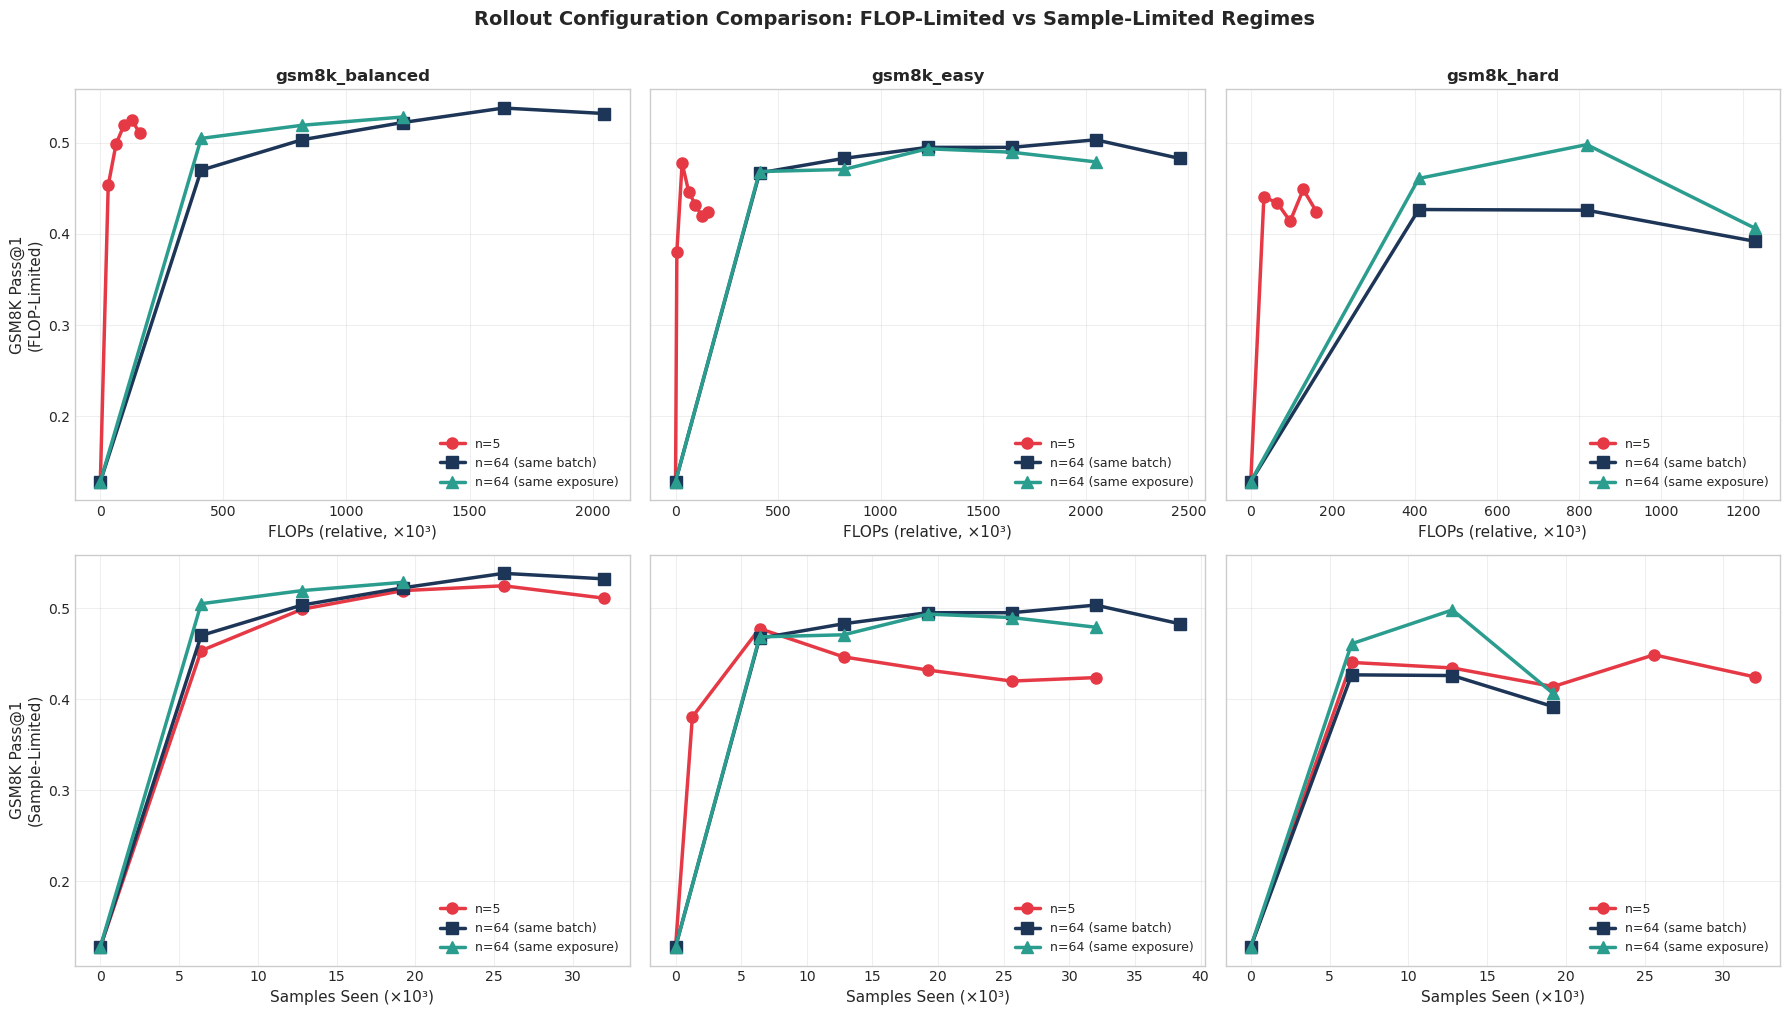

In [11]:
# Plot 4: Rollout efficiency comparison - FLOP-limited vs Sample-limited
# Shows how different rollout configs compare when controlling for FLOPs or samples

plt.style.use("seaborn-v0_8-whitegrid")

rl_valid = rl_df[rl_df["gsm8k_p1"].notna()].copy()

# Find data splits that have multiple config types
splits_with_multiple = []
for train_data in rl_valid["train_data"].unique():
    configs_available = rl_valid[rl_valid["train_data"] == train_data]["config_type"].unique()
    if len(configs_available) > 1:
        splits_with_multiple.append(train_data)

if splits_with_multiple:
    n_plots = len(splits_with_multiple)
    
    colors = {"n5": "#e63946", "n64_same_batch": "#1d3557", "n64_same_exposure": "#2a9d8f"}
    markers = {"n5": "o", "n64_same_batch": "s", "n64_same_exposure": "^"}
    labels = {"n5": "n=5", "n64_same_batch": "n=64 (same batch)", "n64_same_exposure": "n=64 (same exposure)"}
    
    x_options = [
        ("flops_consumed", "FLOPs (relative, ×10³)", 1/1000, "FLOP-Limited"),
        ("samples_seen", "Samples Seen (×10³)", 1/1000, "Sample-Limited"),
    ]
    
    fig, axes = plt.subplots(2, n_plots, figsize=(6 * n_plots, 10), sharey='row')
    if n_plots == 1:
        axes = axes.reshape(-1, 1)
    
    for row_idx, (x_col, x_label, scale, regime_name) in enumerate(x_options):
        for col_idx, train_data in enumerate(splits_with_multiple):
            ax = axes[row_idx, col_idx]
            subset = rl_valid[rl_valid["train_data"] == train_data]
            
            for cfg_type in ["n5", "n64_same_batch", "n64_same_exposure"]:
                cfg_data = subset[subset["config_type"] == cfg_type].sort_values(x_col)
                if cfg_data.empty:
                    continue
                
                if base_gsm8k_p1 is not None:
                    x_vals = [0] + (cfg_data[x_col] * scale).tolist()
                    scores = [base_gsm8k_p1] + cfg_data["gsm8k_p1"].tolist()
                else:
                    x_vals = (cfg_data[x_col] * scale).tolist()
                    scores = cfg_data["gsm8k_p1"].tolist()
                
                ax.plot(x_vals, scores,
                       marker=markers.get(cfg_type, "o"), color=colors.get(cfg_type, "#457b9d"), 
                       linewidth=2.5, markersize=8, label=labels.get(cfg_type, cfg_type))
            
            if row_idx == 0:
                ax.set_title(f"{train_data}", fontsize=12, fontweight="bold")
            ax.set_xlabel(x_label, fontsize=11)
            if col_idx == 0:
                ax.set_ylabel(f"GSM8K Pass@1\n({regime_name})", fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.legend(loc="lower right", fontsize=9)
    
    fig.suptitle("Rollout Configuration Comparison: FLOP-Limited vs Sample-Limited Regimes", 
                 fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.savefig("rollout_efficiency_flop_sample.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No data splits have results for multiple configurations")


/tmp/ipykernel_3869932/1958907246.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


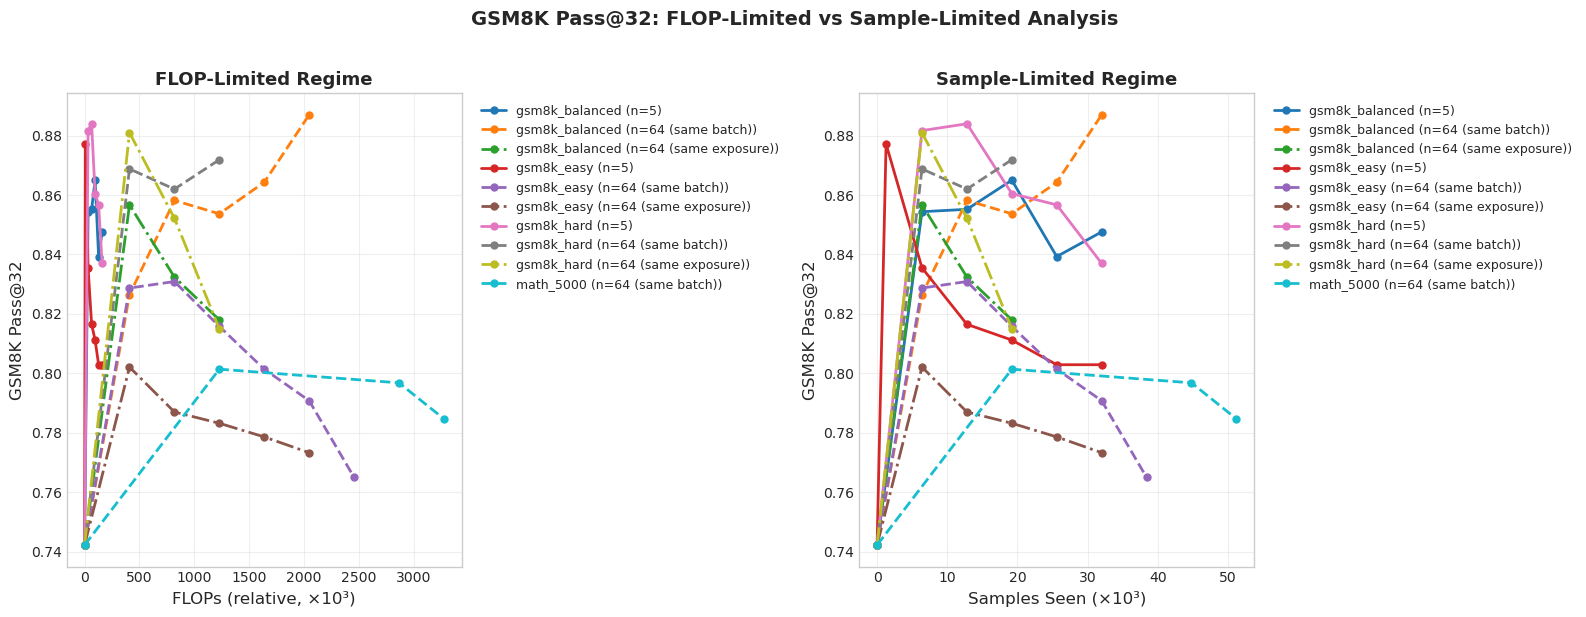

In [12]:
# Plot 5: GSM8K Pass@32 - FLOP-Limited vs Sample-Limited Analysis
# Shows all configurations with FLOPs and samples_seen on x-axis

plt.style.use("seaborn-v0_8-whitegrid")

rl_p32_valid = rl_df[rl_df["gsm8k_p32"].notna()].copy()

if not rl_p32_valid.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    configs = rl_p32_valid.groupby(["train_data", "config_type"]).size().reset_index()[["train_data", "config_type"]]
    cmap = plt.cm.get_cmap("tab10")
    linestyles = {"n5": "-", "n64_same_batch": "--", "n64_same_exposure": "-."}
    config_labels = {"n5": "n=5", "n64_same_batch": "n=64 (same batch)", "n64_same_exposure": "n=64 (same exposure)"}
    
    x_options = [
        ("flops_consumed", "FLOPs (relative, ×10³)", 1/1000, "FLOP-Limited Regime"),
        ("samples_seen", "Samples Seen (×10³)", 1/1000, "Sample-Limited Regime"),
    ]
    
    for ax_idx, (x_col, x_label, scale, title) in enumerate(x_options):
        ax = axes[ax_idx]
        
        for i, (_, config) in enumerate(configs.iterrows()):
            train_data = config["train_data"]
            cfg_type = config["config_type"]
            
            data = rl_p32_valid[(rl_p32_valid["train_data"] == train_data) & 
                               (rl_p32_valid["config_type"] == cfg_type)].sort_values(x_col)
            
            color = cmap(i % 10)
            ls = linestyles.get(cfg_type, "-")
            label = config_labels.get(cfg_type, cfg_type)
            
            if base_gsm8k_p32 is not None:
                x_vals = [0] + (data[x_col] * scale).tolist()
                scores = [base_gsm8k_p32] + data["gsm8k_p32"].tolist()
            else:
                x_vals = (data[x_col] * scale).tolist()
                scores = data["gsm8k_p32"].tolist()
            
            ax.plot(x_vals, scores,
                   marker="o", color=color, linestyle=ls, linewidth=2, markersize=5,
                   label=f"{train_data} ({label})")
        
        ax.set_xlabel(x_label, fontsize=12)
        ax.set_ylabel("GSM8K Pass@32", fontsize=12)
        ax.set_title(title, fontsize=13, fontweight="bold")
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle("GSM8K Pass@32: FLOP-Limited vs Sample-Limited Analysis", fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.savefig("gsm8k_p32_flop_vs_sample.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No Pass@32 results found")
